In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

CIFAR-10:
  x_train_10: (45000, 32, 32, 3)
  x_val_10:   (5000, 32, 32, 3)
  x_test_10:  (10000, 32, 32, 3)
Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0400 - val_loss: 0.0225
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0220 - val_loss: 0.0193
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0189 - val_loss: 0.0176
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0175 - val_loss: 0.0168
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0167 - val_loss: 0.0158
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0162 - val_loss: 0.0160
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 9/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0156 - val_loss: 0.0152
Epoch 10/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0157 - val_loss: 0.0153
Epoch 11/30
352/352 ━━━━━━━━━━━

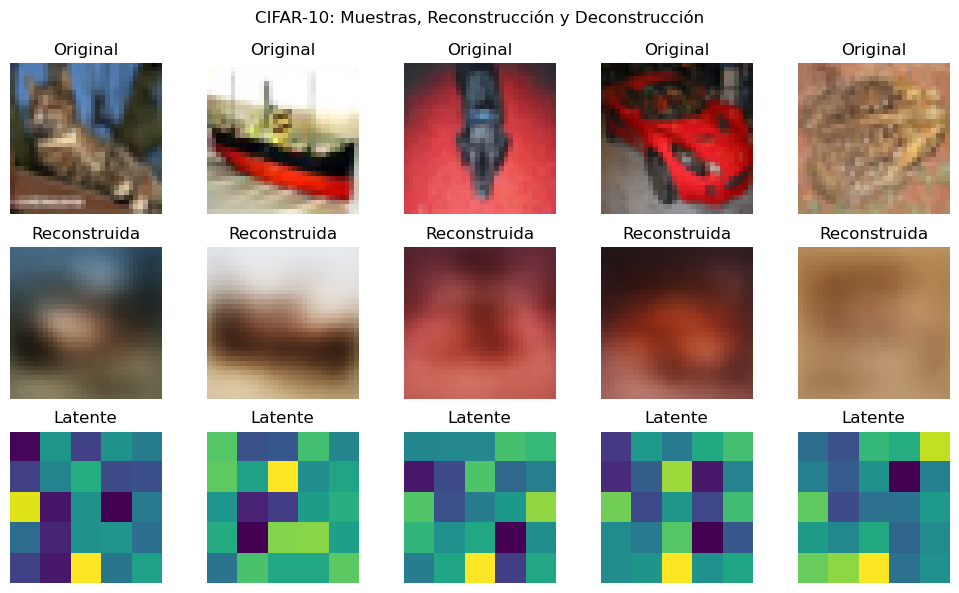

In [2]:
# 1. Cargar y preparar datos
(x_train_10, _), (x_test_10, _) = cifar10.load_data()
x_train_10 = x_train_10.astype("float32") / 255.0
x_test_10  = x_test_10.astype("float32") / 255.0

# Conjunto de validación (opcional, para monitorear)
x_val_10 = x_train_10[-5000:]
x_train_10 = x_train_10[:-5000]

print("CIFAR-10:")
print("  x_train_10:", x_train_10.shape)
print("  x_val_10:  ", x_val_10.shape)
print("  x_test_10: ", x_test_10.shape)

# 2. Construir un autoencoder con la mejor arquitectura
def build_autoencoder_cifar10(input_shape=(32, 32, 3)):
    """
    Construye un autoencoder para CIFAR-10 con la arquitectura
    y parámetros del mejor individuo.
    """
    inputs = keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    
    # Primera capa oculta con 234 neuronas y activación tanh
    x = layers.Dense(234, activation='tanh')(x)
    
    # Capa latente (bottleneck) con 25 neuronas y activación tanh
    x = layers.Dense(25, activation='tanh', name='latent_layer')(x)
    
    # Segunda capa oculta (decodificación) con 234 neuronas y activación tanh
    x = layers.Dense(234, activation='tanh')(x)
    
    # Capa de salida
    x = layers.Dense(np.prod(input_shape), activation='sigmoid')(x)
    outputs = layers.Reshape(input_shape)(x)
    
    model = keras.Model(inputs, outputs, name="autoencoder_cifar10_best")
    return model

# Crear el autoencoder con la nueva arquitectura
autoencoder_10 = build_autoencoder_cifar10()

# Compilar el modelo con el learning rate del mejor individuo
autoencoder_10.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005028815550494495),
    loss='mse'
)

# Entrenar el modelo (entrenamiento rápido de demostración)
autoencoder_10.fit(
    x_train_10, x_train_10,
    validation_data=(x_val_10, x_val_10),
    epochs=30,
    batch_size=128,
    verbose=1
)

# 4. Construir un modelo encoder para obtener la representación latente
latent_layer_10 = autoencoder_10.get_layer("latent_layer").output
encoder_10 = keras.Model(autoencoder_10.input, latent_layer_10)

# 5. Visualizar muestras, reconstrucciones y representaciones latentes
num_samples = 5
indices = np.random.choice(range(x_test_10.shape[0]), num_samples, replace=False)
sample_images_10 = x_test_10[indices]

# Obtener representación latente y salida reconstruida
latent_repr_10 = encoder_10.predict(sample_images_10)
reconstruct_10 = autoencoder_10.predict(sample_images_10)

plt.figure(figsize=(10, 6))
for i in range(num_samples):
    # Imagen original
    ax = plt.subplot(3, num_samples, i+1)
    plt.imshow(sample_images_10[i])
    plt.title("Original")
    plt.axis("off")
    
    # Reconstruida
    ax = plt.subplot(3, num_samples, i+1+num_samples)
    plt.imshow(reconstruct_10[i])
    plt.title("Reconstruida")
    plt.axis("off")
    
    # Representación latente (modo heatmap si es factible)
    ax = plt.subplot(3, num_samples, i+1+2*num_samples)
    latent_vec = latent_repr_10[i]
    side = int(np.sqrt(latent_vec.shape[0]))
    if side * side == latent_vec.shape[0]:
        latent_2d = latent_vec.reshape(side, side)
    else:
        # En caso de que no sea cuadrada, recortamos para demo
        latent_2d = latent_vec[:side*side].reshape(side, side)
    plt.imshow(latent_2d, cmap='viridis')
    plt.title("Latente")
    plt.axis("off")

plt.suptitle("CIFAR-10: Muestras, Reconstrucción y Deconstrucción")
plt.tight_layout()
plt.show()

In [3]:
from sklearn.metrics import mean_squared_error

# Redimensionar las imágenes para convertirlas en vectores
original_images_flat = sample_images_10.reshape(sample_images_10.shape[0], -1)
reconstructed_images_flat = reconstruct_10.reshape(reconstruct_10.shape[0], -1)

# Calcular MSE para cada imagen
mse_per_image = [
    mean_squared_error(original, reconstructed)
    for original, reconstructed in zip(original_images_flat, reconstructed_images_flat)
]

# Calcular el MSE promedio
mse_avg = np.mean(mse_per_image)

# Mostrar resultados
print("MSE por imagen:", mse_per_image)
print("MSE promedio:", mse_avg)


MSE por imagen: [0.013078052, 0.026648542, 0.014432172, 0.018078094, 0.0056958203]
MSE promedio: 0.015586535
